GN = Group Normalization  
With params = 42,268  ; on 9th epoch, test_acc=72.19%  
removed GAP

https://github.com/rajayourfriend/EraV2/tree/main/S8



# 1. Import external libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.optim.lr_scheduler import StepLR
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

#### Basically working model
#### Img Aug RandomRotation
#### StepLR Scheduler
#### Train & Test Graphs

# 2. Convolutional Neural Network (model) architecture

In [ ]:
!wget https://raw.githubusercontent.com/rajayourfriend/EraV2/main/S8/model.py
!ls model.py

--2024-03-20 14:41:06--  https://raw.githubusercontent.com/rajayourfriend/EraV2/main/S8/model.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6938 (6.8K) [text/plain]
Saving to: ‘model.py’

model.py            100%[===================>]   6.78K  --.-KB/s    in 0s      

2024-03-20 14:41:06 (88.7 MB/s) - ‘model.py’ saved [6938/6938]

model.py


In [ ]:
!ls /content/model.py
!pwd

/content/model.py
/content


In [ ]:
import model

#### RuntimeError: running_mean should contain 8 elements not 4
Implies check the bn channels, whether it matches with the ouput channel of its previous layer.

# 3. Display summary of model

In [ ]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available() #bool
str_gpu_cpu = "cuda" if use_cuda else "cpu" #string
device = torch.device(str_gpu_cpu)
print("device is " + str_gpu_cpu)
model = model.Net_GN_S8().to(device)
summary(model, input_size=(3, 32, 32))

device is cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
         GroupNorm-2           [-1, 16, 32, 32]              32
            Conv2d-3           [-1, 16, 32, 32]           2,320
         GroupNorm-4           [-1, 16, 32, 32]              32
            Conv2d-5           [-1, 16, 34, 34]             272
         GroupNorm-6           [-1, 16, 34, 34]              32
         MaxPool2d-7           [-1, 16, 17, 17]               0
            Conv2d-8           [-1, 16, 17, 17]           2,320
         GroupNorm-9           [-1, 16, 17, 17]              32
           Conv2d-10           [-1, 32, 17, 17]           4,640
        GroupNorm-11           [-1, 32, 17, 17]              64
           Conv2d-12           [-1, 32, 15, 15]           9,248
        GroupNorm-13           [-1, 32, 15, 15]              64
           Conv2d-14    

/content/model.py:68: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


# 4. Preparation of dataset  

In [ ]:

SEED = 1
torch.manual_seed(SEED)
batch_size = 128
batch_size = 64
#batch_size = 4

# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

                        #transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                        #transforms.RandomResizedCrop(size=(28, 28), antialias=True), #Not so good
                        #transforms.RandomAffine(20),




100%|██████████| 170498071/170498071 [00:03<00:00, 43480883.42it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def imshowfor10(img, predlbl, tglbl):
    rows = 5
    columns = 2
    fig = plt.figure(figsize=(16, 16))
    for i in range(1, columns*rows +1):
        ax = fig.add_subplot(rows, columns, i)
        # print("img.type = " + str(type(img)))
        # print("img.len = " + str(len(img)))
        # print("img.shape = " + str(np.asarray(img).shape))
        tmpimg = img[i-1] / 2 + 0.5     # unnormalize
        npimg = tmpimg.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        lbls = str("pred=" + predlbl[i-1]) + " ,  " + "target=" +str(tglbl[i-1])
        ax.set_xlabel(lbls)
    plt.show()

<class 'torch.utils.data.dataloader.DataLoader'>
<class 'torch.utils.data.dataloader._MultiProcessingDataLoaderIter'>
<class 'torch.Tensor'>
torch.Size([64, 3, 32, 32])
<class 'torch.Tensor'>


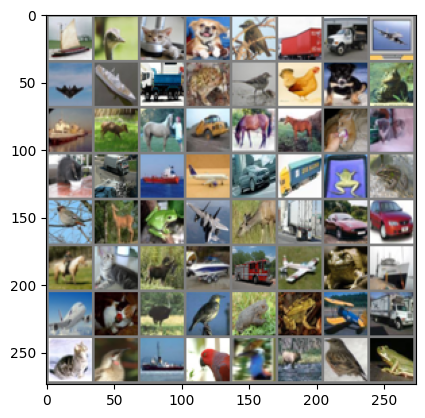

ship  bird  cat   dog   bird  truck truck plane plane ship  truck frog  bird  bird  dog   frog  ship  deer  horse truck horse horse dog   cat   cat   truck ship  plane car   truck frog  frog  bird  deer  frog  plane deer  truck car   car   horse cat   deer  ship  truck plane frog  ship  plane cat   bird  bird  frog  frog  plane truck cat   bird  ship  bird  bird  deer  bird  frog 


In [ ]:
print(type(trainloader))

#random sample from data from training images
dataiter = iter(trainloader)
print(type(dataiter))
#dir(dataiter)
images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(type(labels))
imshow(utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# 5. Train and Test Functions

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
global ngimg
global nglabel
global tglabel

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        train_losses.append(loss)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        pbar.set_description(desc= f'Batch_id = {batch_idx} train_acc = {100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    ngimg = []
    nglabel = []
    tglabel = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            test_losses.append(test_loss)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            ng = pred.ne(target.view_as(pred))
            n = len(ng)
            ngimg += [iter[j] for iter in [data] for j in range(n) if ng[j] == True]
            nglabel += [classes[pred[j]] for j in range(n) if ng[j] == True]
            tglabel += [classes[target[j]] for j in range(n) if ng[j] == True]

    test_loss /= len(test_loader.dataset)

    print('\n  Test set: Average loss: {:.4f}, test_acc = ({:.2f}%)\n'.format(
        test_loss,
        100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))
    return [ngimg, nglabel, tglabel]



# 6. Run the model with a device and an optimizer

In [ ]:

#model = Net4().to(device) #already done
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#RAJA ToDo Try ADAM optimizer
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
result = []


ep = 10
for epoch in range(1, ep):
    print('epoch = {}'.format(epoch))
    train(model, device, trainloader, optimizer, epoch)
    scheduler.step()
    ngimg, nglabel, tglabel = test(model, device, testloader)

epoch = 1


Batch_id = 781 train_acc = 33.69: 100%|██████████| 782/782 [00:20<00:00, 38.80it/s]



  Test set: Average loss: 1.4924, test_acc = (46.12%)

epoch = 2


Batch_id = 781 train_acc = 48.93: 100%|██████████| 782/782 [00:20<00:00, 38.00it/s]



  Test set: Average loss: 1.2897, test_acc = (53.73%)

epoch = 3


Batch_id = 781 train_acc = 56.94: 100%|██████████| 782/782 [00:20<00:00, 38.20it/s]



  Test set: Average loss: 1.1394, test_acc = (59.73%)

epoch = 4


Batch_id = 781 train_acc = 62.73: 100%|██████████| 782/782 [00:20<00:00, 37.27it/s]



  Test set: Average loss: 1.0216, test_acc = (63.41%)

epoch = 5


Batch_id = 781 train_acc = 66.55: 100%|██████████| 782/782 [00:20<00:00, 37.52it/s]



  Test set: Average loss: 0.9519, test_acc = (66.54%)

epoch = 6


Batch_id = 781 train_acc = 69.69: 100%|██████████| 782/782 [00:20<00:00, 37.39it/s]



  Test set: Average loss: 1.0029, test_acc = (65.19%)

epoch = 7


Batch_id = 781 train_acc = 75.68: 100%|██████████| 782/782 [00:20<00:00, 38.35it/s]



  Test set: Average loss: 0.8243, test_acc = (71.90%)

epoch = 8


Batch_id = 781 train_acc = 76.90: 100%|██████████| 782/782 [00:20<00:00, 38.96it/s]



  Test set: Average loss: 0.8222, test_acc = (72.16%)

epoch = 9


Batch_id = 781 train_acc = 77.53: 100%|██████████| 782/782 [00:19<00:00, 39.69it/s]



  Test set: Average loss: 0.8144, test_acc = (72.19%)



Find 10 misclassified images for the BN, GN and LN model and show them as a 5x2 image matrix in separately annotated images

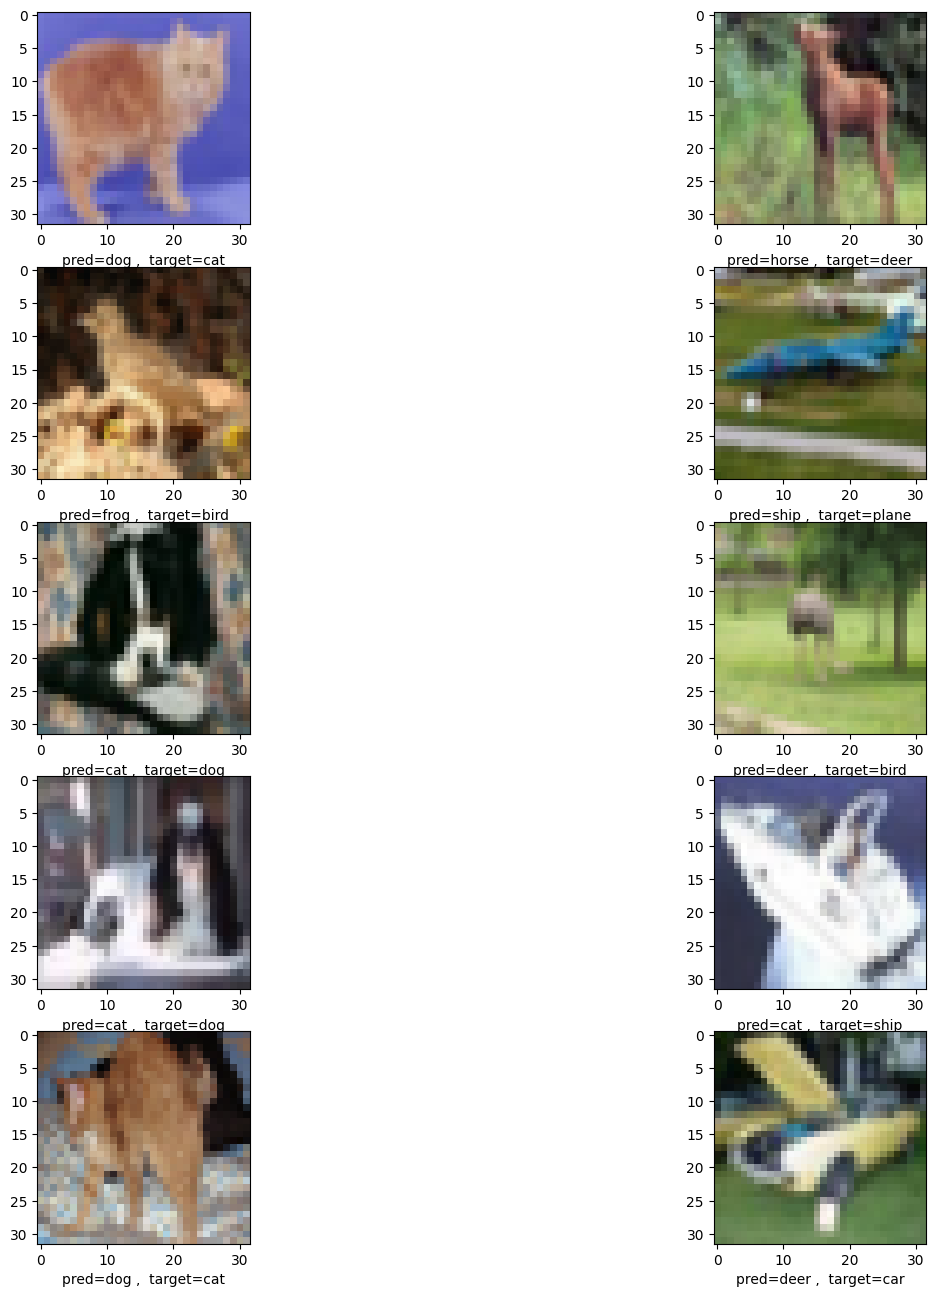

In [ ]:


ngimg10 = torch.stack(ngimg[-10:])
nglabel10 = nglabel[-10:]
tglabel10 = tglabel[-10:]
ngimg10 = ngimg10.cpu()
imshowfor10(ngimg10, nglabel10, tglabel10)

In [ ]:
#random sample from data from training images
dataiter = iter(trainloader)
print("dataiter type = " + str(type(dataiter)))


print("ndi len = " + str(len(next(dataiter))))
a, b = next(dataiter)

print("a type = " + str(type(a)))
print("b type = " + str(type(b)))
print("a len = " + str(len(a)))
print("a len = " + str(a.shape))
print("b len = " + str(b.shape))

dataiter type = <class 'torch.utils.data.dataloader._MultiProcessingDataLoaderIter'>
ndi len = 2
a type = <class 'torch.Tensor'>
b type = <class 'torch.Tensor'>
a len = 64
a len = torch.Size([64, 3, 32, 32])
b len = torch.Size([64])
